# Phase 2 - Data preprocessing
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


## Loading the data

In [129]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
devices_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/devices.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

## Merging datasets

Із попередньої фази, після аналізу кожного датасету ми дійшли до висновку, що датасел із профілями, ми не будемо включати до об'єднаного датасету оскільки він мав багато проблем, зокрема такі як велика кількість значень, різні формати даних, дублікаучі значення атрибутів як `"user_id"` та `"imei"`, що просто ускладнює з'єднання. Також даний датасет не мав ніяких важливих атрибутів, які ще й би можна було закодувати у числовй формат, щоб допомогли нам у предикціїї щначення атрибуту `"mwra"`.

Також у минулій фазі ми помітили, що 2 датасети, процеси і коннекшин можна з'єднати оскільки вони логічно пов'язані і мають декілька спільних атрибутів, які є спільними для них обох:

In [130]:
connections_data['ts'].equals(processes_data['ts']) and connections_data['mwra'].equals(processes_data['mwra']) and connections_data['imei'].equals(processes_data['imei'])

True

In [131]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()

Що ж стосується датасету девайсів, то він має декілька атрибутів які стосуються локації, які ми б могли спробувати з'єднати.

### З'єднання з датасетом пристроїв
Давайте також перевіримо чи можемо ми з'єднати ще датасет пристроїв, але як ми пам'ятаємо з фази 1 в цьому датасеті дуже багато дублікатів `"imei"` що може ускладнити нам з'єднування, оскільки якщо в таблиці процесів/коннекшинів буде `"imei"`, яке не буде в таблиці девайсів ми можемо отримати нульові значення і при чисті просто втратити цю інформацію, тому перед тим як це зробити варто це перевірити:

In [132]:
devices_imei_unique = devices_data.drop_duplicates(subset=['imei'], keep='first')
devices_imei_unique.shape[0]

500

In [133]:
result = pd.merge(devices_imei_unique, processes_data, on='imei', how='right')
result.shape[0]

15145

In [134]:
result.dropna()
result.shape[0]

15145

Як ми бачимо після мерджу ми не втратили жодної інформації, тобто для кожного рядка в коонекшинах є відповідний девайс, тому можемо спокійно мерджувати датасет девайсів до спільних даних:

In [135]:
merged_data = pd.merge(devices_imei_unique, merged_data, on='imei', how='right')
merged_data.shape[0]

14965

Також чатиною датасету девайсів є атрибут `"location"`, який можна розділити на колонки `"continent"` та `"city"`:

In [136]:
merged_data[['continent', 'city']] = merged_data['location'].str.split('/', expand=True, n=1).apply(lambda x: x.tolist() if len(x.dropna()) > 1 else [x[0], None], axis=1, result_type='expand')
merged_data = merged_data.drop(['location'], axis=1)

## Розподіл даних

In [137]:
train_data, test_data = train_test_split(merged_data, test_size=0.25)

# train_data, test_data = None, None

# if not (os.path.exists('data/train_data_before.csv') and os.path.exists('data/test_data_before.csv')):
#     train_data, test_data = train_test_split(merged_data, test_size=0.25)
#     train_data.to_csv('data/train_data_before.csv')
#     test_data.to_csv('data/test_data_before.csv')
# else:
#     train_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/data/train_data_before.csv')
#     test_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/data/test_data_before.csv')

print('Training sample contains: '+ str(len(train_data))+' records')
print('Test sample contains: '+ str(len(test_data))+' records')

Training sample contains: 11223 records
Test sample contains: 3742 records


## Кодування нечислових атрибутів


У цьому розділі ми закодуємо нечислові атрибути для того щоб їх ми надалі могли використовувати для аналізу.

Давайте глянемо які саме атрибути потрібно закодувати:

In [138]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11223 entries, 7298 to 2631
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   latitude                    11223 non-null  float64
 1   longitude                   11223 non-null  float64
 2   store_name                  11223 non-null  object 
 3   code                        11202 non-null  object 
 4   imei                        11223 non-null  int64  
 5   ts                          11223 non-null  object 
 6   mwra                        11223 non-null  float64
 7   p.android.packageinstaller  11223 non-null  float64
 8   p.system                    11223 non-null  float64
 9   p.android.externalstorage   11223 non-null  float64
 10  p.android.documentsui       11223 non-null  float64
 11  p.android.gm                11223 non-null  float64
 12  p.android.settings          11223 non-null  float64
 13  p.android.chrome            11223 

Як ми бачимо більшість атрибутів є вже у числовому форматі, і лише деякі з них не є, а саме:

- store_name
- code
- imei
- ts
- continent
- city

Проте такі атрибути як:

- store_name
- code
- city

мають велику варіацію, що буде складно мапувати, та й не матиме великого значення.

`"imei"` є ж просто ід девайсу, тому вона також уже не має для нас значення.

Тому ці атрибути ми просто видалимо.

In [139]:
train_data = train_data.drop(['store_name', 'code', 'city','imei'], axis=1)

Атрибути `"continent"` та `"ts"` ми ж все ж перетворимо у числові значення.

### Кодування континентів

In [140]:
continent_mapping = {
    'Asia': 1,
    'America': 2,
    'Europe': 3,
    'Africa': 4,
    'Australia': 5,
    'Indian': 6,
    'Pacific': 7
}

train_data['continent'] = train_data['continent'].map(continent_mapping)

In [141]:
train_data['continent'].value_counts()

,count
continent,
1,3465
2,3152
3,3020
4,1342
5,122
6,75
7,47


Як ми тепер бачимо у нас є нові числові значення.

### Перетворення таймстампів

In [142]:
train_data['ts'] = pd.to_datetime(train_data['ts'], format='%Y-%m-%d %H:%M:%S')

train_data['year'] = train_data['ts'].dt.year
train_data['month'] = train_data['ts'].dt.month
train_data['day'] = train_data['ts'].dt.day
train_data['hour'] = train_data['ts'].dt.hour
train_data['minute'] = train_data['ts'].dt.minute
train_data['second'] = train_data['ts'].dt.second

train_data = train_data.drop(['ts'], axis=1)
train_data.head()

,latitude,longitude,mwra,p.android.packageinstaller,p.system,p.android.externalstorage,p.android.documentsui,p.android.gm,p.android.settings,p.android.chrome,...,c.UCMobile.x86,c.android.vending,c.raider,continent,year,month,day,hour,minute,second
7298,16.45500,120.58750,0.0,7.79426,6.49004,13.13484,12.22883,8.69838,12.89976,7.81026,...,49.67263,70.49153,19.25448,1,2018,5,10,11,38,0
5365,39.96097,-75.60804,0.0,12.78693,10.42500,12.38569,13.21265,7.10462,10.07287,3.81936,...,50.09665,29.47590,73.70159,2,2018,5,9,3,25,0
3718,40.65538,-74.38987,0.0,9.41026,12.44123,12.57957,9.87297,9.70396,14.69923,9.61400,...,52.50136,78.80752,66.22600,2,2018,5,7,23,58,0
8127,19.21667,73.08333,0.0,8.52975,12.48270,7.99084,10.96054,16.52182,10.09828,8.44682,...,40.14345,15.81514,89.78947,1,2018,5,11,1,27,0
5854,8.48714,-13.23560,0.0,10.77330,12.37664,12.42822,8.36022,12.48448,14.66715,10.25139,...,49.08845,69.39056,47.43430,4,2018,5,9,11,34,0


In [143]:
train_data[['year', 'month','second']].value_counts()

,,,count
year,month,second,
2018,5,0,11223


Як ми можемо бачити `year,	month,	second` мають фіксовані значення тому ми їх теж видалимо.

In [144]:
train_data = train_data.drop(['year', 'month','second'], axis=1)

## Missing values

Як уже ми згадували в попередній фазі 2 датасети процесів і коннекшинів, взагалі не мали жодний Missing values, а датасет дивайсів мав лише 1 Missing value, що і так не потрапило до об'єднаного датасету, оскільки це значення було в атрибуті `коді`, який ми і так видалили.

In [145]:
train_data.isnull().sum()

,0
latitude,0
longitude,0
mwra,0
p.android.packageinstaller,0
p.system,0
p.android.externalstorage,0
p.android.documentsui,0
p.android.gm,0
p.android.settings,0
p.android.chrome,0


## Outliers

In [146]:
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = column[(column < lower_bound) | (column > upper_bound)]
    cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

    return cleaned_column

<Axes: >

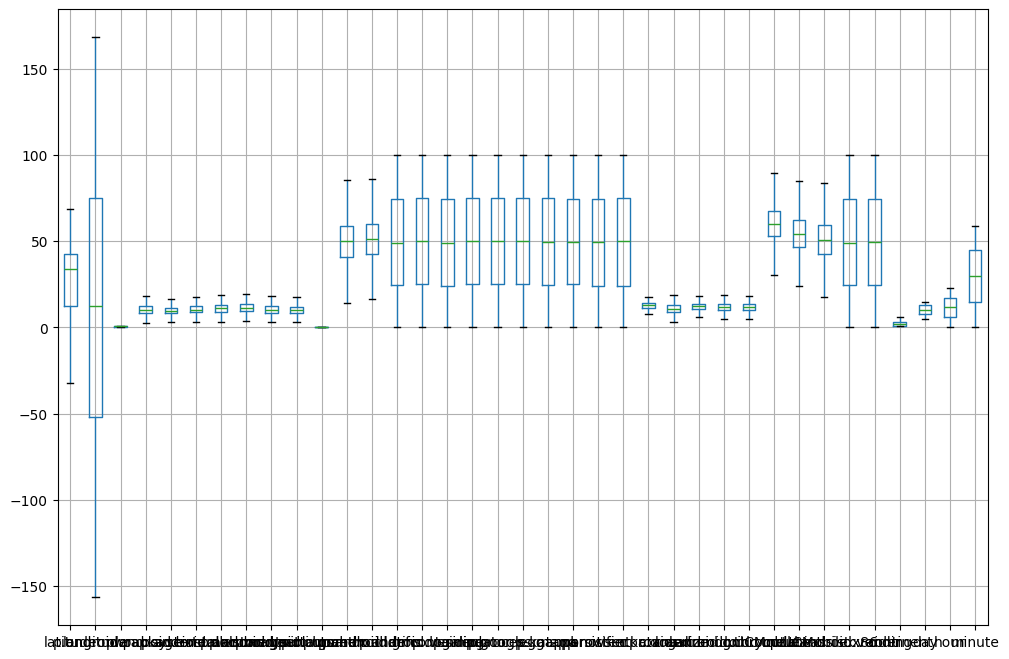

In [147]:
clean_data = train_data.drop("mwra", axis=1).apply(remove_outliers)
train_data[train_data.columns.delete(train_data.columns.get_loc("mwra"))] = clean_data

train_data.boxplot(figsize=(12, 8))

Як ми бачимо після чищення немає жодного аутлаєра.

## Attibutes grouping

Як ми поміти з першої фази різні атрибути мають різні дистрибуції, тому ми вирішили їх поділити на групи на основі подібності їх дистрибуцій.

Це зроблено перед використанням технік для трансформування та скелінгу, оскільки деякі з цих технік підходять краще для нормальних дистрибуцій, в той час як інші краще підходять для інших.

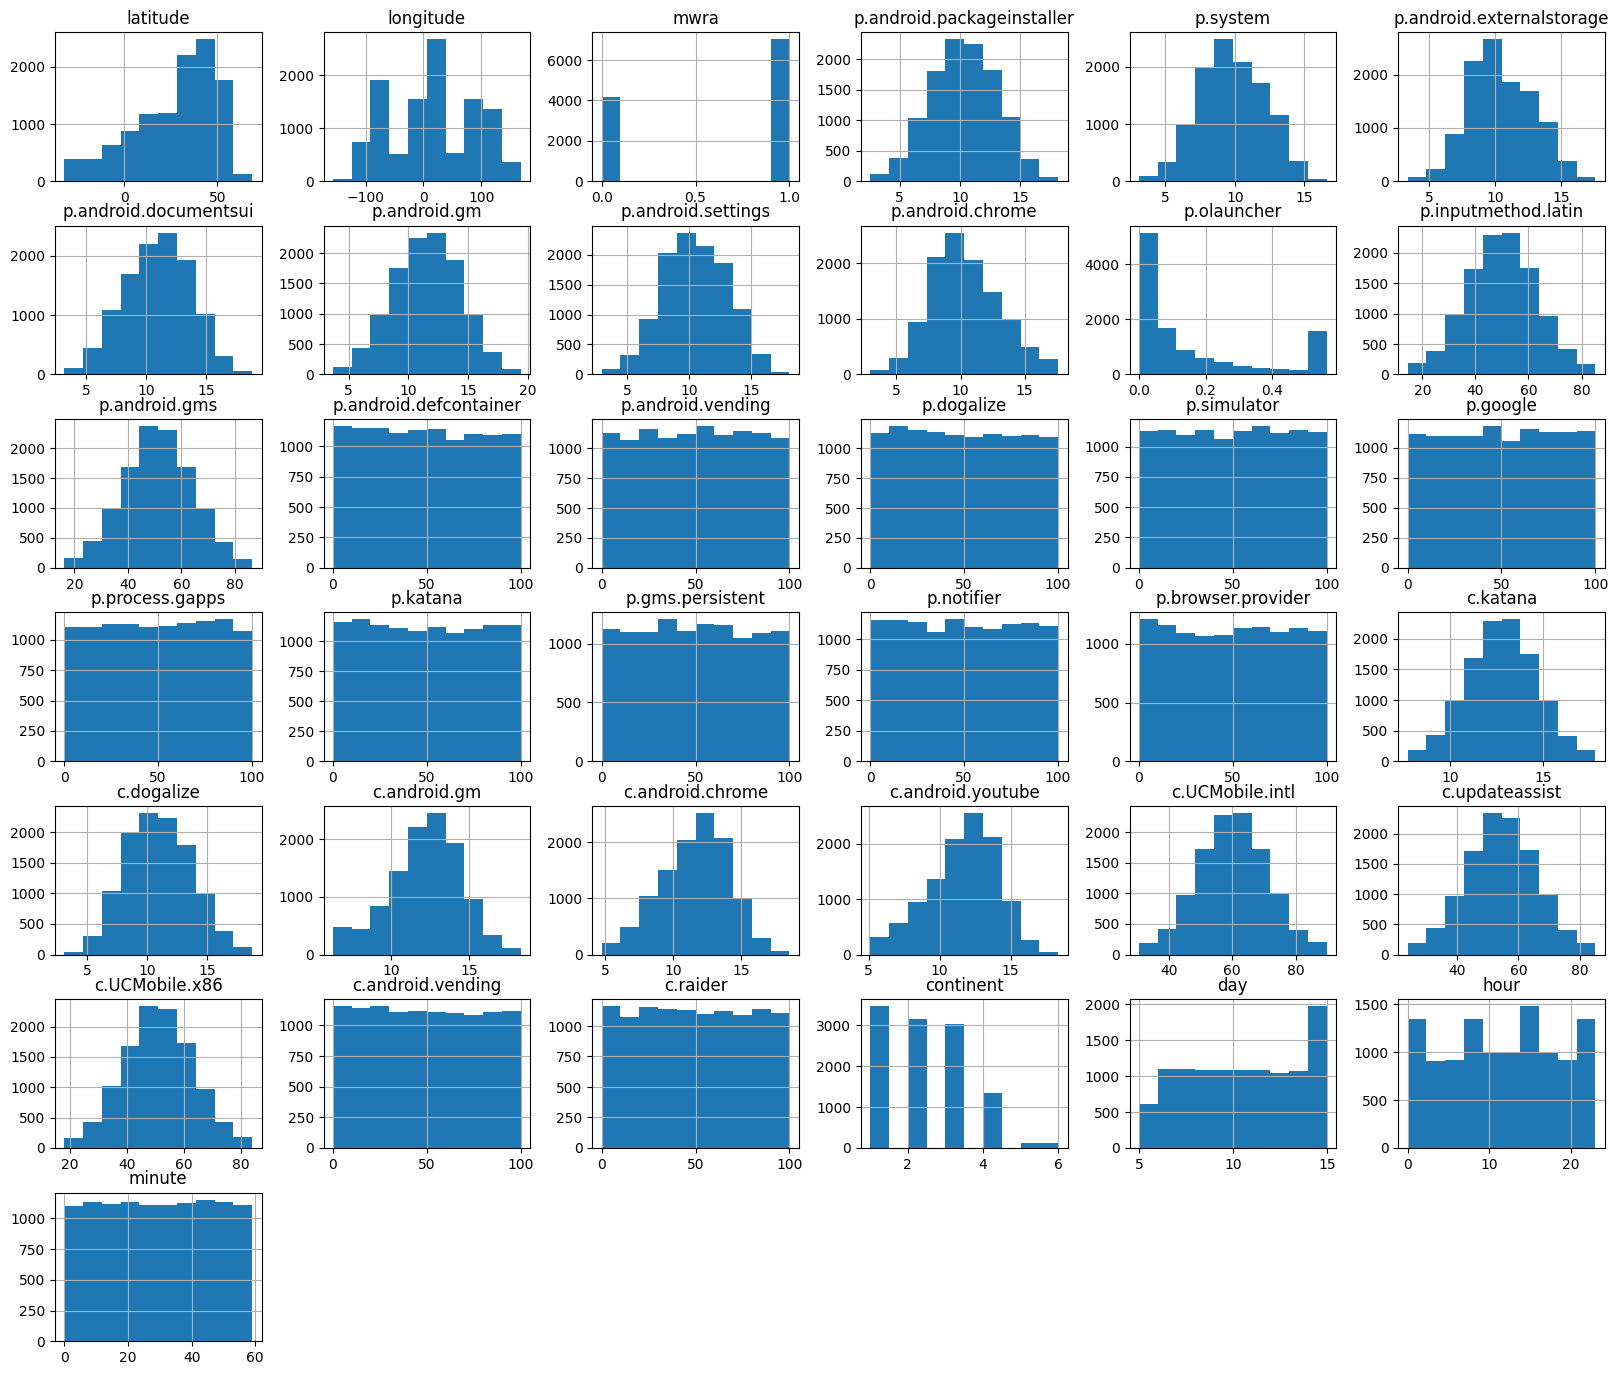

In [148]:
train_data.hist(figsize=(20, 17))
plt.show()

Давайте тепер поділимо наші атрибути на групи на основі подібності їх дистрибуцій:

![grouping](https://raw.githubusercontent.com/myrres0/IAU-2024/main/img/grouping.png)

Атрибут `"mwra"` ми не відносили до жодної з дистрибуцій оскільки це атрибут, який ми хочемо предикувати.

In [149]:
first_group = ['p.android.packageinstaller', 'p.system', 'p.android.externalstorage',
               'p.android.documentsui', 'p.android.gm', 'p.android.settings',
               'p.android.chrome', 'p.inputmethod.latin', 'p.android.gms',
               'c.katana', 'c.dogalize', 'c.android.gm','c.android.chrome',
               'c.android.youtube', 'c.UCMobile.intl', 'c.updateassist',
               'c.UCMobile.x86']

second_group = ['p.android.defcontainer', 'p.android.vending', 'p.dogalize',
                'p.simulator', 'p.google', 'p.process.gapps', 'p.katana',
                'p.gms.persistent', 'p.notifier', 'p.browser.provider',
                'c.android.vending', 'c.raider', 'minute']

third_group = ['latitude', 'longitude', 'p.olauncher', 'continent', 'day', 'hour']

## Data transformers
In next steps we are going to try different data transformers to see which one will give us the best results.

### Power transformer (yeo-johnson)
The PowerTransformer is a technique used to make numerical data resemble a Gaussian distribution more closely, which is often required for many machine learning models that operate under the assumption of normal distribution.

In [150]:
group1_df = train_data[first_group].copy()

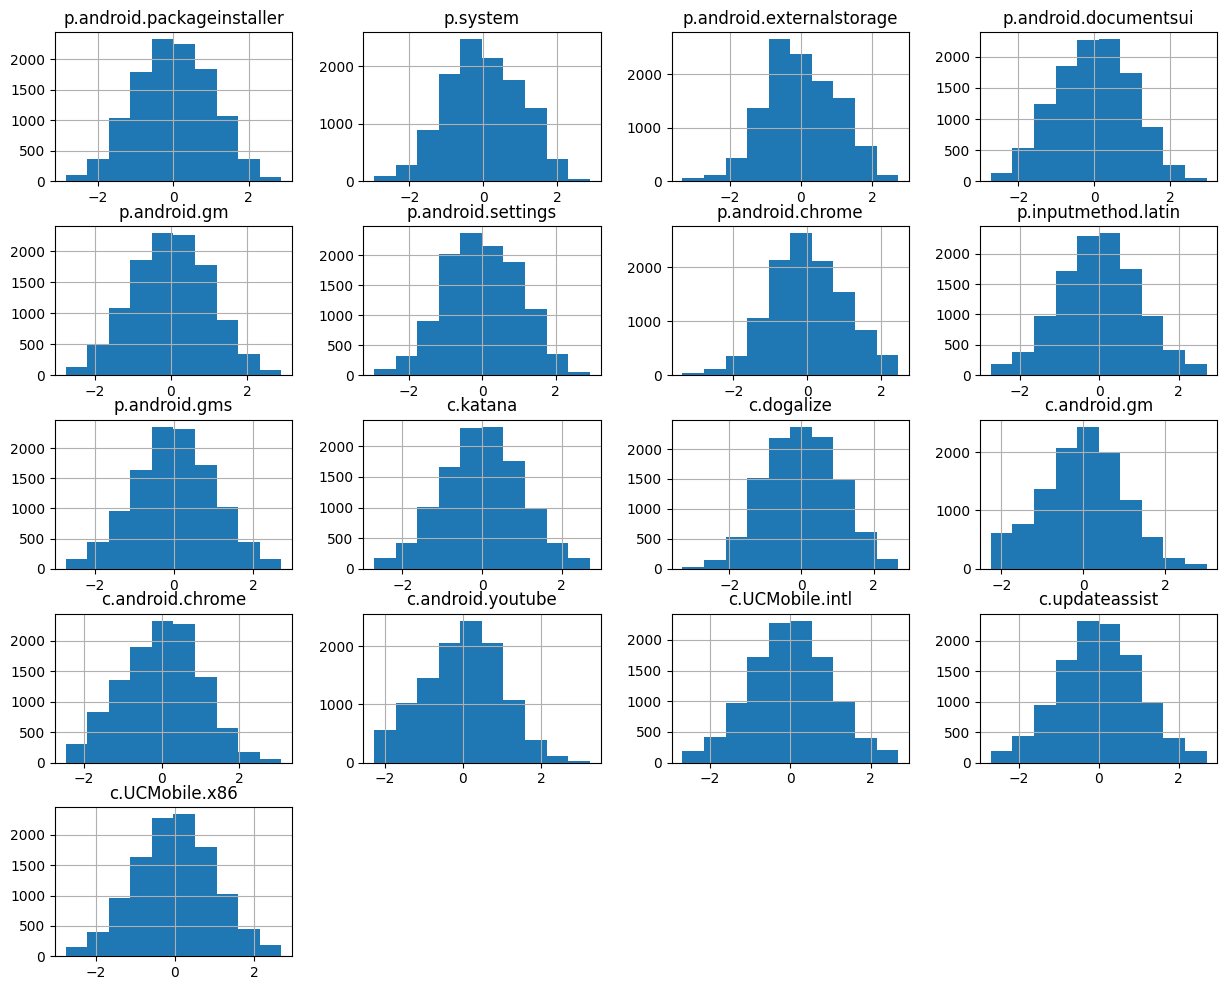

In [151]:
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

data_transformed = power_transformer.fit_transform(group1_df)
data_transformed = pd.DataFrame(data_transformed, columns=group1_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

Power transformer transforms data to similarly normally distributed data. It this example we used attributes with similar distribution to normal distribution to apply power transformer. That why the difference between the original and transformed data is not such visible.

Let's also apply power transformer to second and third group of attributes.

In [152]:
group2_df = train_data[second_group].copy()

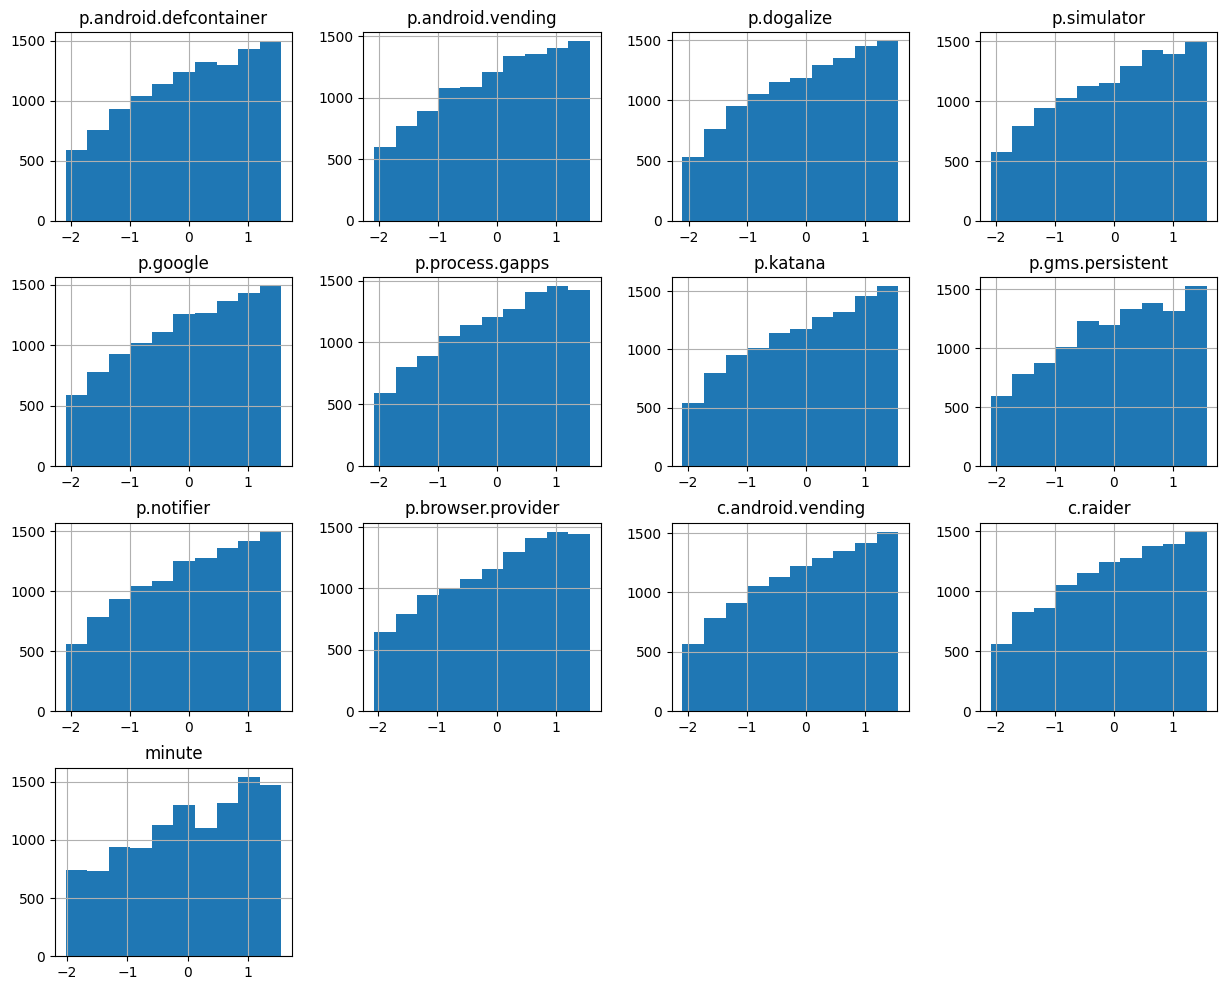

In [153]:
data_transformed = power_transformer.fit_transform(group2_df)
data_transformed = pd.DataFrame(data_transformed, columns=group2_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

In [154]:
group3_df = train_data[third_group].copy()

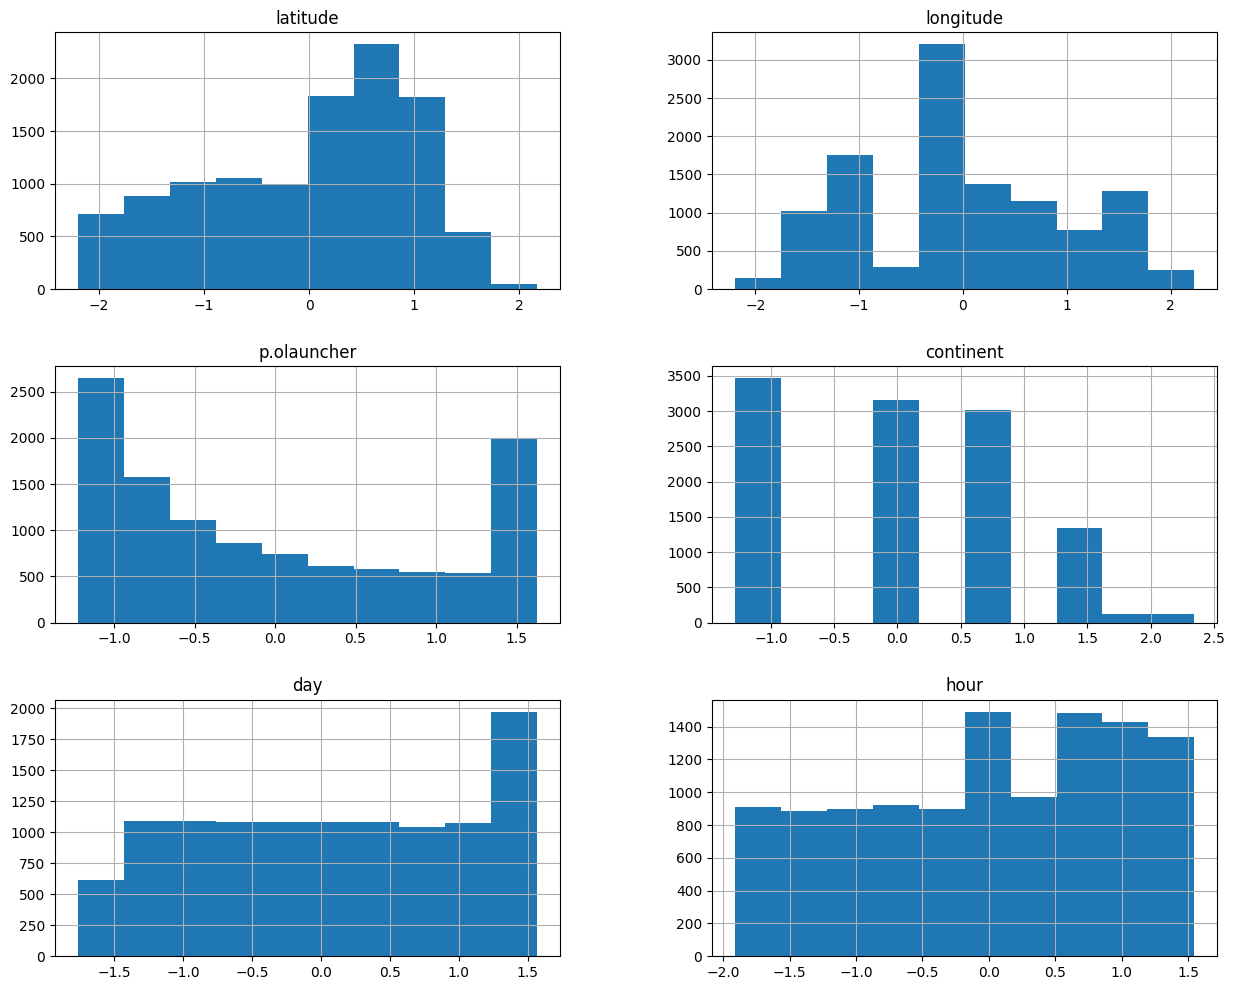

In [155]:
data_transformed = power_transformer.fit_transform(group3_df)
data_transformed = pd.DataFrame(data_transformed, columns=group3_df.columns)

data_transformed.hist(figsize=(15, 12))
plt.show()

As we can see on the pictures above in the second and third group the final distribution isn't close to normal distribution. That's why we will try another transformer.

### Quantile Transformer
Quantile transformation is an statistics approach to change the distribution a dataset is to normal distribution. Quantile transform works by changing the probability distribution of a measure to a different probability distribution.

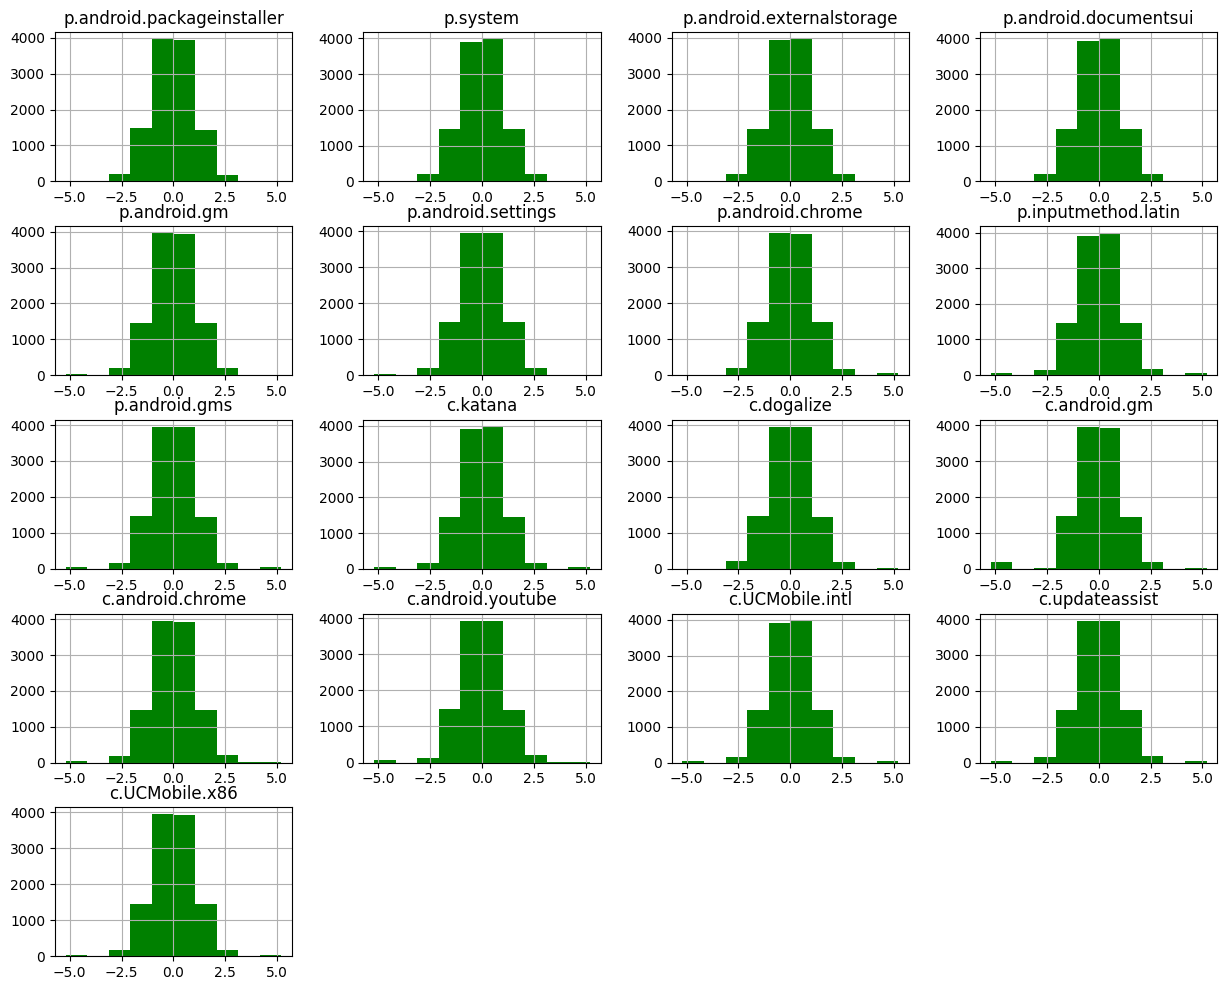

In [156]:
quantile_transformet = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)

data_transformed = quantile_transformet.fit_transform(group1_df)
data_transformed = pd.DataFrame(data_transformed, columns=group1_df.columns)

data_transformed.hist(figsize=(15, 12), color='green')
plt.show()


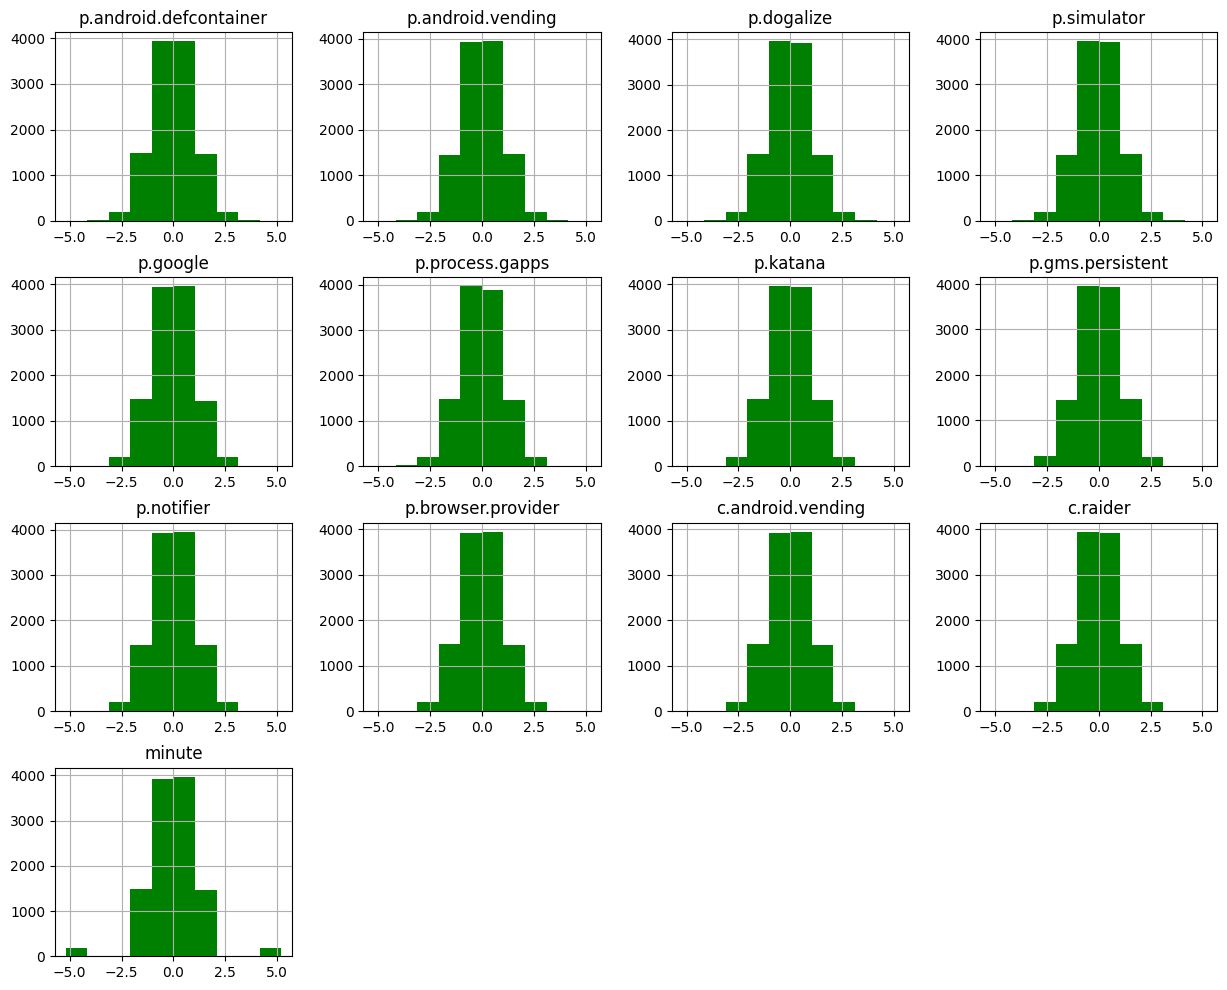

In [157]:
data_transformed = quantile_transformet.fit_transform(group2_df)
data_transformed = pd.DataFrame(data_transformed, columns=group2_df.columns)

data_transformed.hist(figsize=(15, 12),color="green")
plt.show()

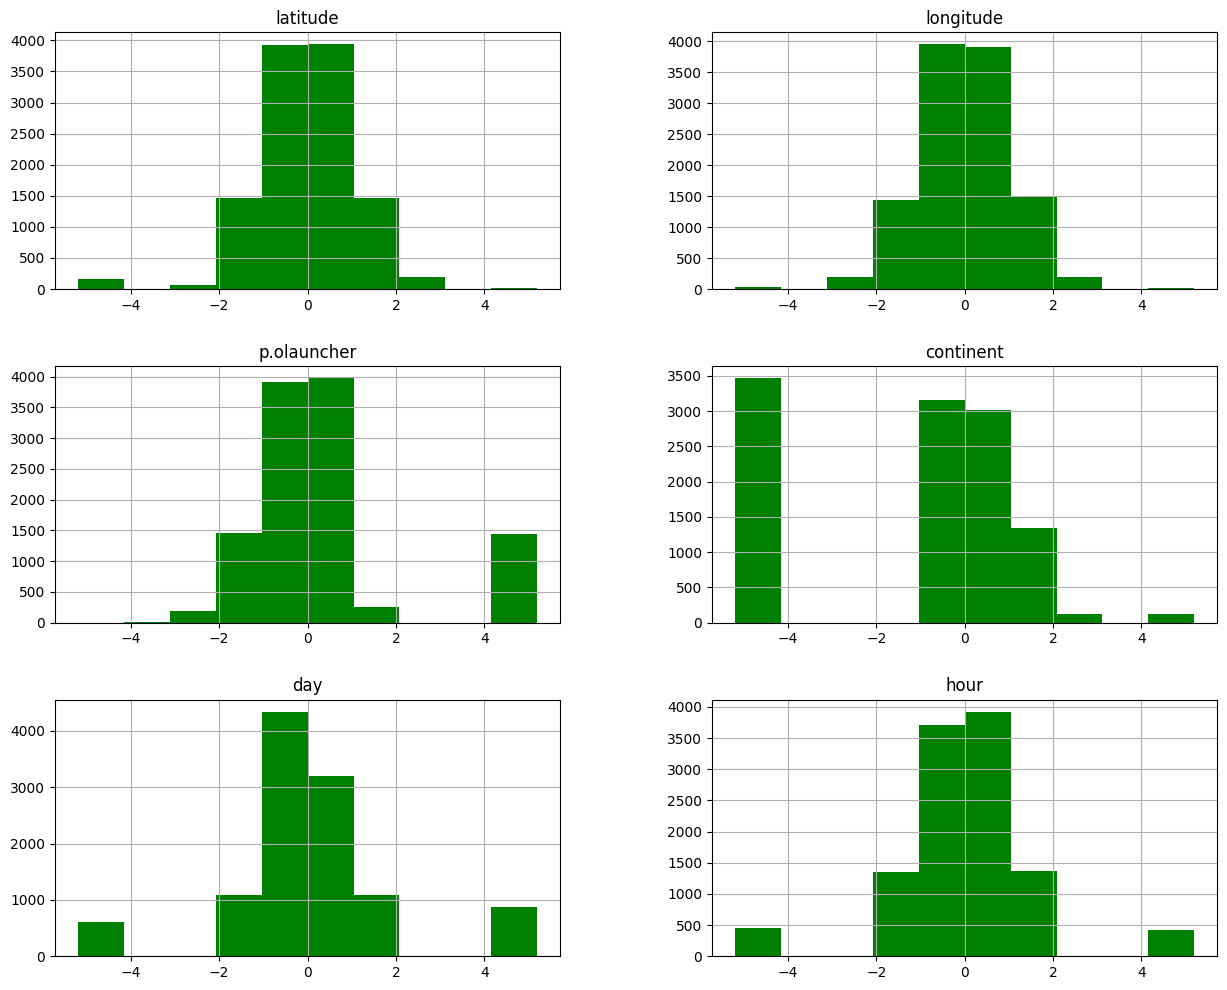

In [158]:
data_transformed = quantile_transformet.fit_transform(group3_df)
data_transformed = pd.DataFrame(data_transformed, columns=group3_df.columns)

data_transformed.hist(figsize=(15, 12), color='green')
plt.show()

The quantile transformer is a non-linear transformation. It smooths out unusual distributions and is less influenced by outliers than scaling methods. It also reduces the impact of outliers. That's why it worked well for the second and third group of attributes.

### Result transforming

After comparison these two transformers for different groups of attributes we can see that quantile transformer worked better for the second and third group of attributes, and power transformer worked better for the first group of attributes.
Let's transform our train data using this information

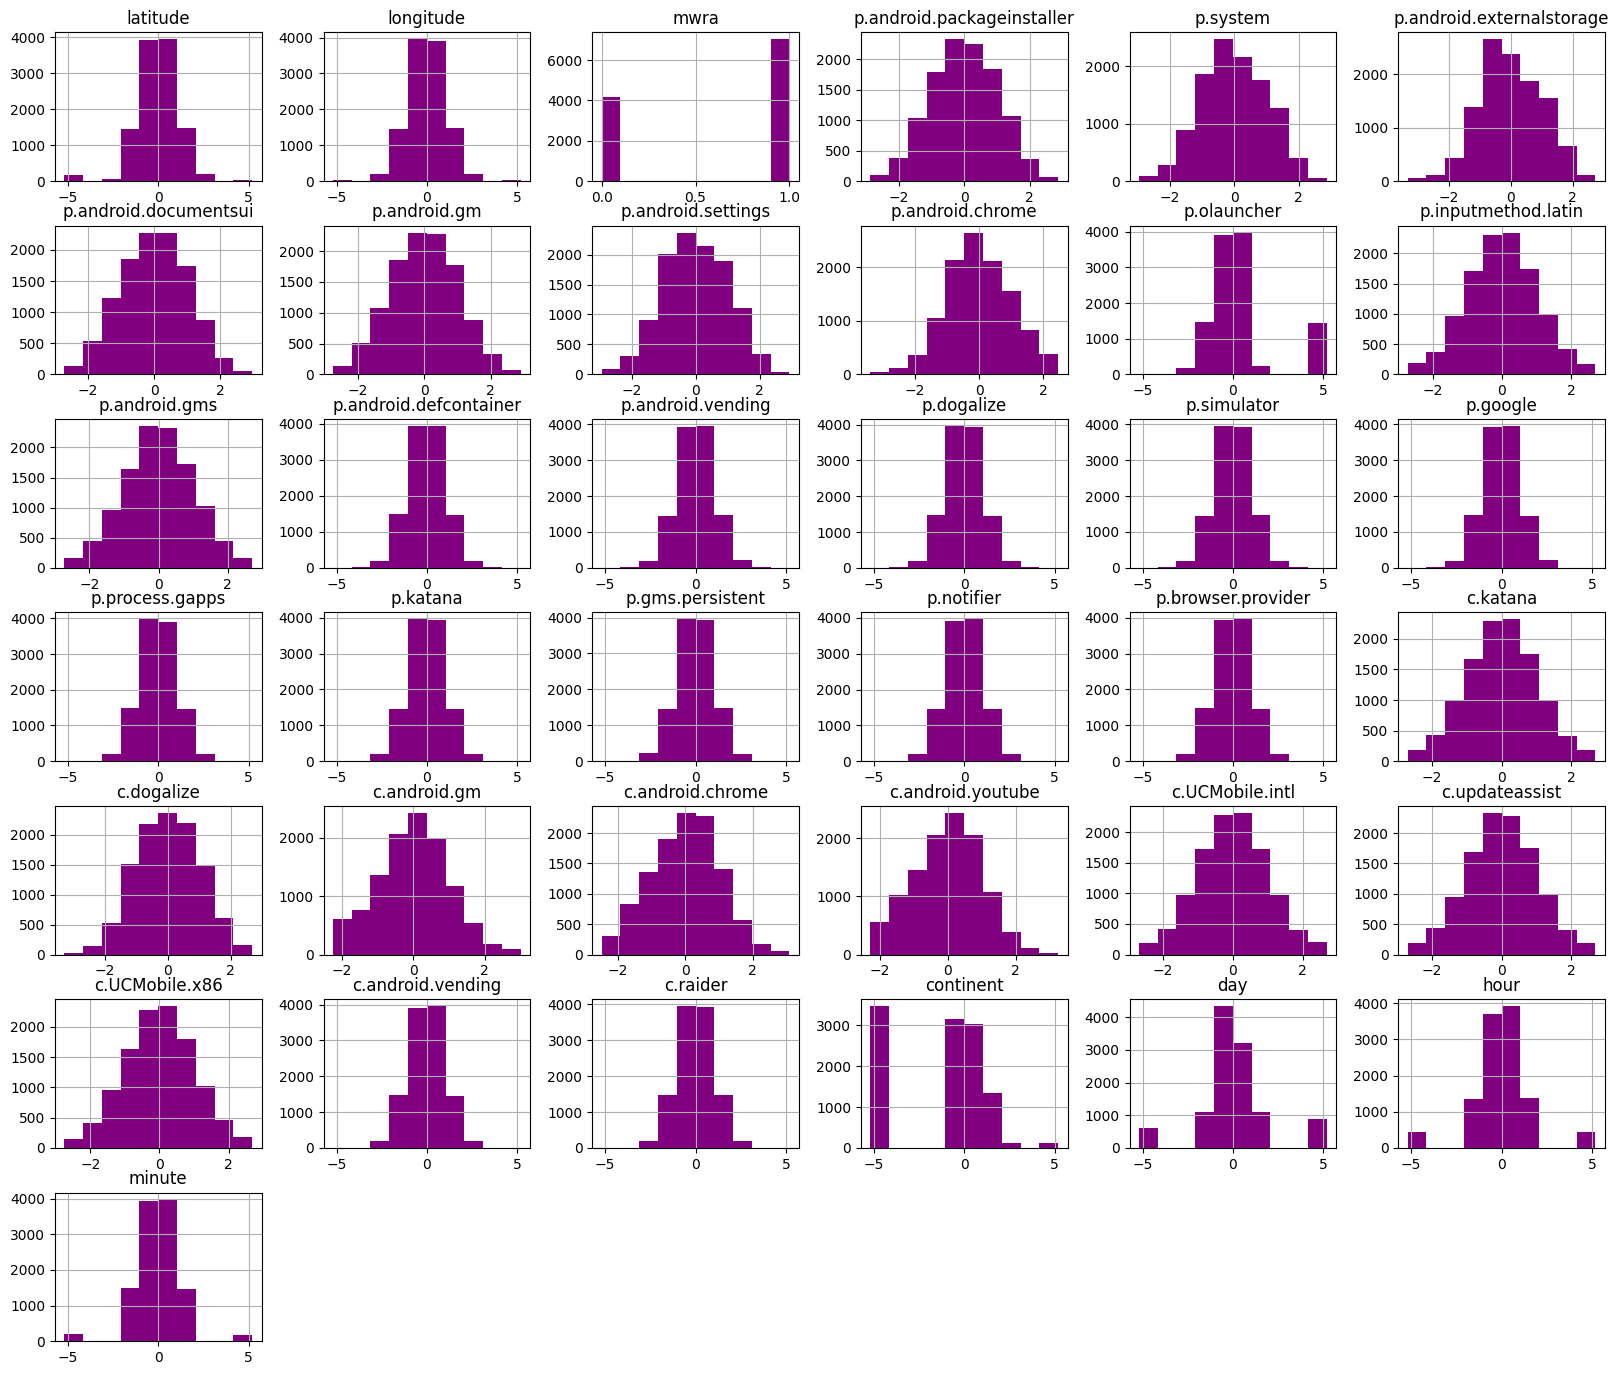

In [159]:
train_data[first_group] = power_transformer.fit_transform(train_data[first_group])
train_data[second_group] = quantile_transformet.fit_transform(train_data[second_group])
train_data[third_group] = quantile_transformet.fit_transform(train_data[third_group])

train_data.hist(figsize=(20, 17), color='purple')
plt.show()

## Data Scaling

"Many machine learning algorithms perform better or when features are relatively similar to normally distributed. Examples of such machine learning algorithms are linear regression,logistic regression, k-Nearest Neighbors algorithm, neural networks, Support Vector Machine, rincipal Components Analysis (PCA), inear Discriminant Analysis (LDA).

There are several scaling approaches such as:

* Normalization.

* Standardization.

* Robust scaler.

They are necessary in the case of very different values within the same feature (for example, city population). Without normalization (and/or standardization), the training could blow up to NaN (not a number) if the gradient update is too large."   
<p align="right">Giang Nguyen, "Introduction to Data Science"</p>

### Main difference

<table>
  <tr>
    <th>Scaling Approach</th>
    <th>Description</th>
    <th>When to Use</th>
  </tr>
  <tr>
    <td><strong>Normalization</strong></td>
    <td>Rescales values to a range, typically [0, 1] or [-1, 1].</td>
    <td>Useful when features have different scales and need to be in the same range for ML algorithms.</td>
  </tr>
  <tr>
    <td><strong>Standardization</strong></td>
    <td>Scales values to have a mean of 0 and a standard deviation of 1 (z-score).</td>
    <td>Commonly used for algorithms assuming a normal distribution, e.g., linear regression, SVM.</td>
  </tr>
  <tr>
    <td><strong>Robust Scaler</strong></td>
    <td>Scales based on the median and IQR (Interquartile Range), making it robust to outliers.</td>
    <td>Ideal for data with outliers, as it uses the median and IQR instead of mean and variance.</td>
  </tr>
</table>


- Uniformly Distributed Features: for features with uniform distributed, Min-Max Scaling (Normalization) might work best to bring values within a fixed range like [0, 1].
- Normally Distributed Features: for features with a normal distribution, Standardization (Z-score scaling) is generally effective as it centers the data around 0 with unit variance, aligning with the natural spread of the data.
- Highly Skewed or Outlier-Prone Features: for features with many outliers or a heavy skew, Robust Scaling (based on median and IQR) can be useful, as it minimizes the influence of extreme values.

### Result scaling

Оскільки після трансформації виглядає, що кожний атрибут має нормальну дистрибуцію, тому в принципі немає значення яким саме методом скалінгу скористатися, давайте це перевіримо:

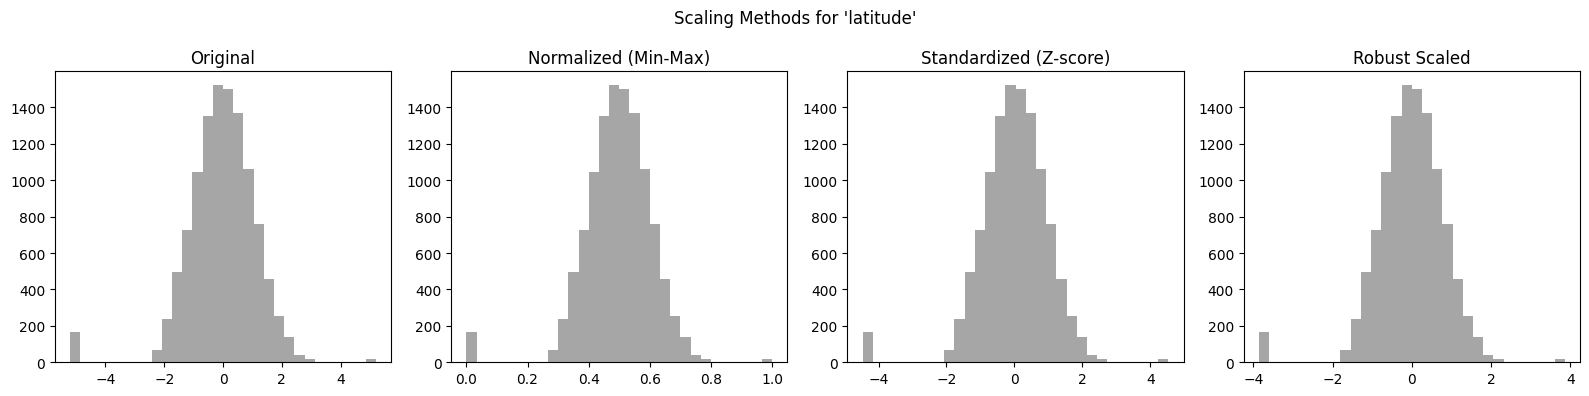

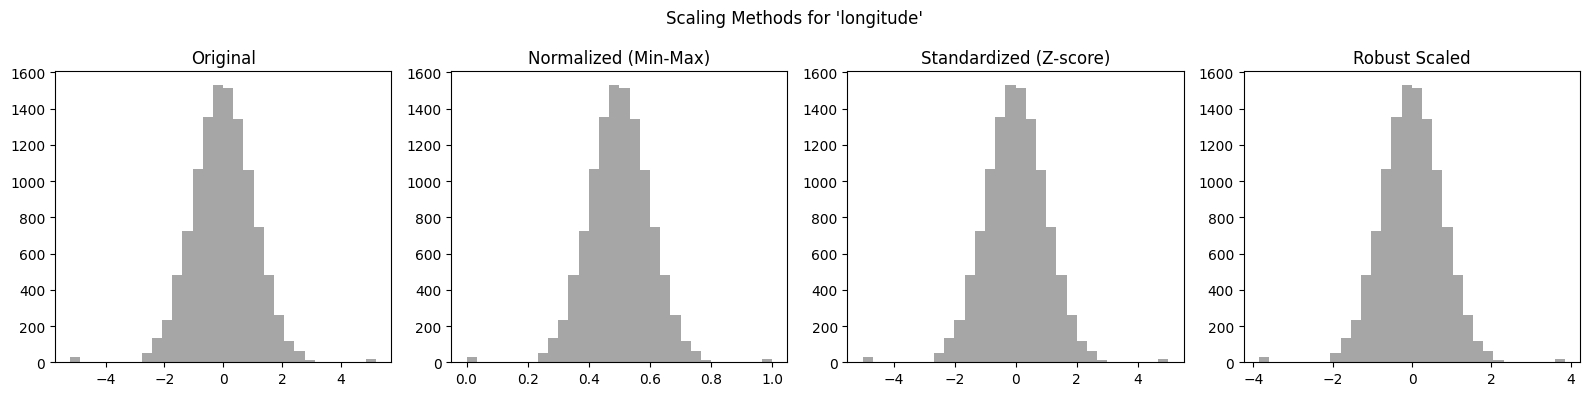

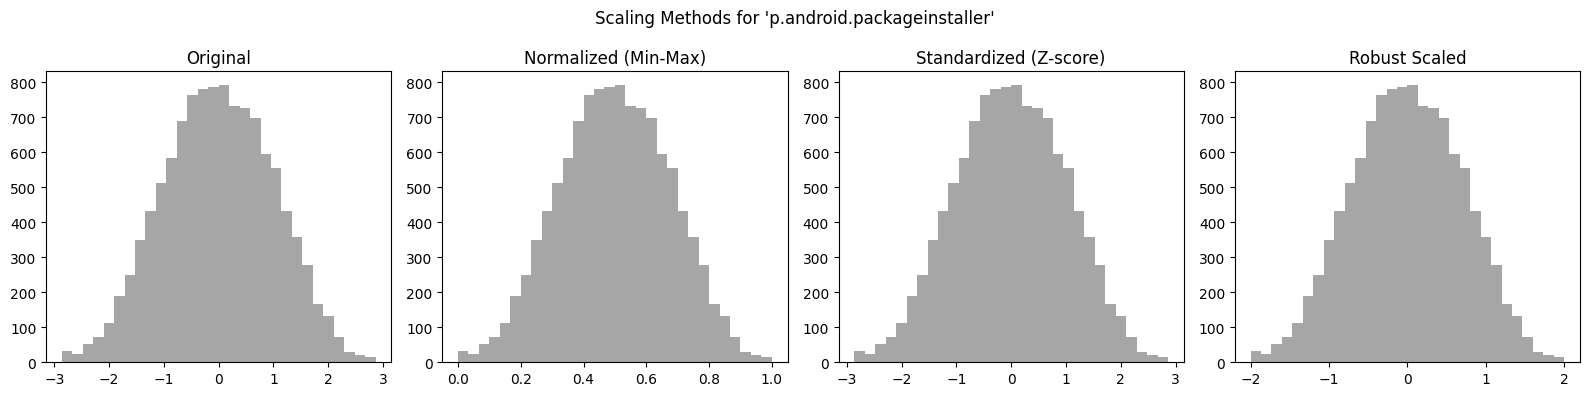

In [160]:
def plot_scaled_distributions(df, number):
    # Define scaling methods and labels
    scalers = {
        "Original": None,
        "Normalized (Min-Max)": MinMaxScaler(),
        "Standardized (Z-score)": StandardScaler(),
        "Robust Scaled": RobustScaler()
    }

    # Loop through each column in the DataFrame
    for column_name in df.columns:

        # Skip the 'mwra' column
        if column_name == 'mwra':
            continue

        if number == 0:
          return
        number = number - 1

        # Set up the plot for each column
        plt.figure(figsize=(16, 4))
        plt.suptitle(f"Scaling Methods for '{column_name}'")

        # Loop through each scaler, apply it, and plot
        for i, (title, scaler) in enumerate(scalers.items(), start=1):
            # If scaler is None, use original data
            if scaler is None:
                data_scaled = df[[column_name]].values
            else:
                data_scaled = scaler.fit_transform(df[[column_name]])

            # Plot the histogram
            plt.subplot(1, len(scalers), i)
            plt.hist(data_scaled, bins=30, color='gray', alpha=0.7)
            plt.title(title)

        # Adjust layout
        plt.tight_layout()
        plt.show()

plot_scaled_distributions(train_data, 3)

Але оскільки в умові завдання написано, що потрібно це зробити різними техніками, тоді для 1 групи ми використаємо `StandardScaler`, оскільки ці дистрибуції мали відпочатку майже нормальну дистрибуцію, для 2 групи використаємо `MinMaxScaler` оскільки в них переважно Уніформна дистрибуція, а для 3 групи `RobustScaler`, оскільки ці значення мали інші дистрибуції, а також атрибут **p.olauncher**, який частиною цієї групи мав екстримальні значення.

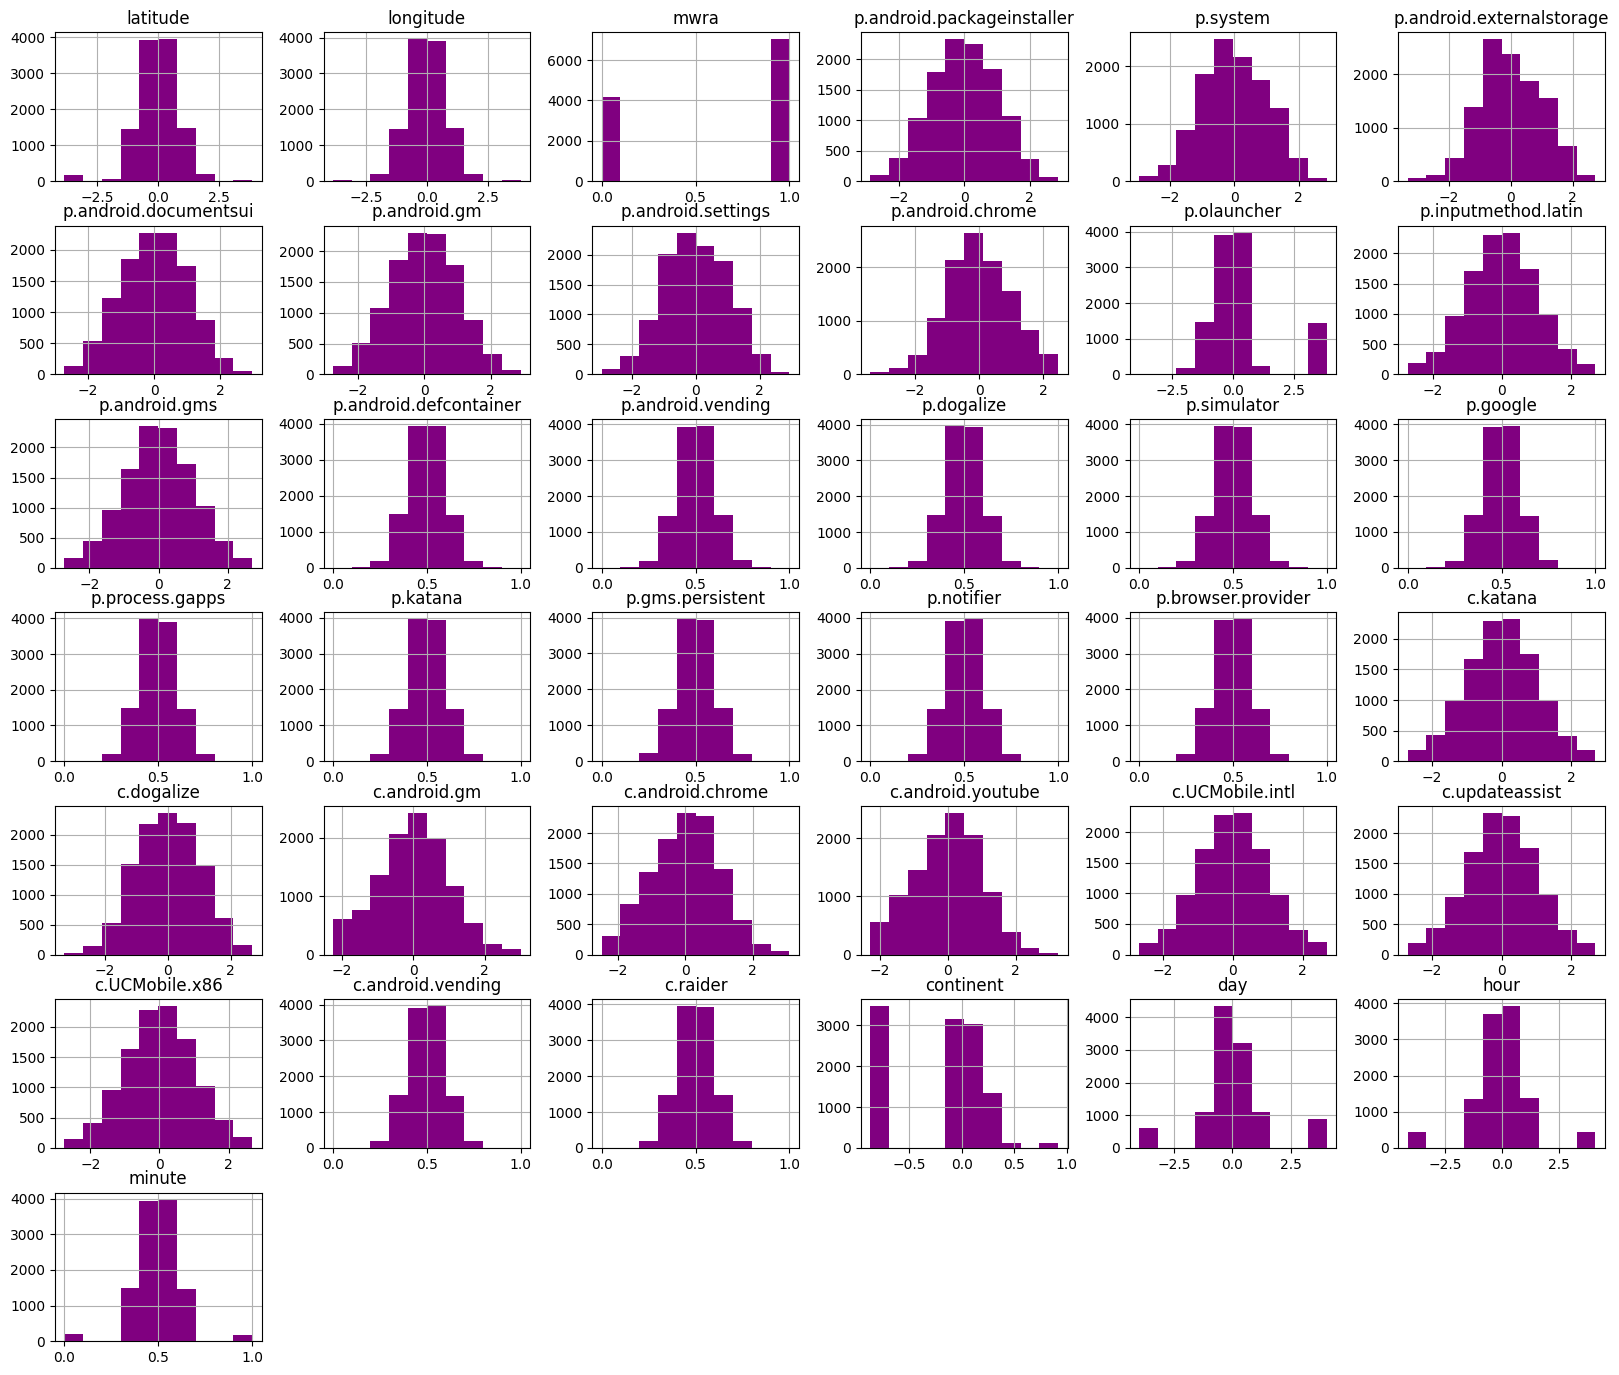

In [161]:
train_data[first_group] = StandardScaler().fit_transform(train_data[first_group])
train_data[second_group] = MinMaxScaler().fit_transform(train_data[second_group])
train_data[third_group] = RobustScaler().fit_transform(train_data[third_group])

train_data.hist(figsize=(20, 17), color='purple')
plt.show()

## Feature selection
Feature selection is a technique used to select a subset of input features that are most relevant to the target(mwra) variable that is being predicted. That way we can focus only on a subset of features that are most important for the prediction.

### Mutual Information (MI)
Mutual Information is a measure of the amount of randomness shared between two random variables X and Y.

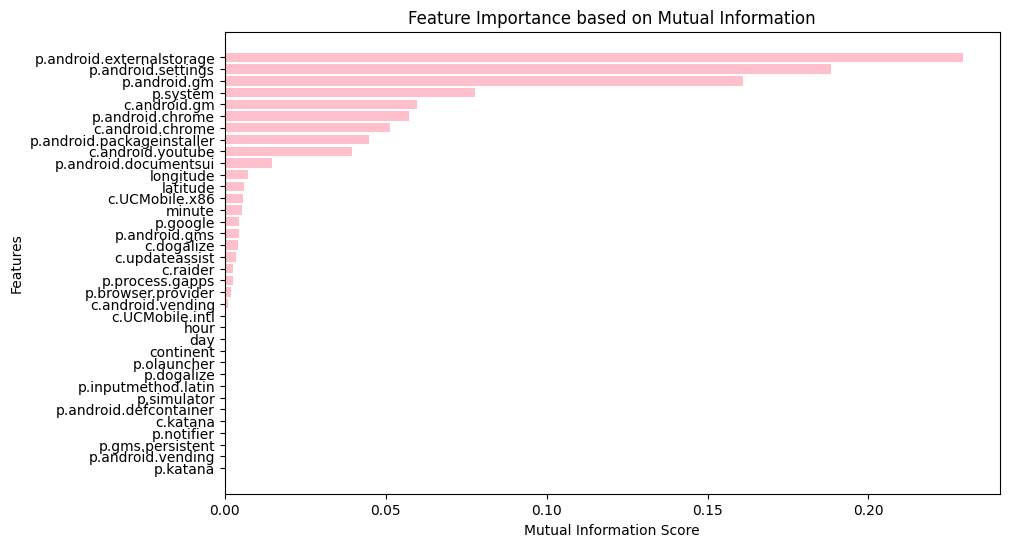

In [162]:
features = train_data.drop(columns=['mwra'])
target = train_data['mwra']

mi_scores = mutual_info_classif(features, target)

mi_scores = pd.DataFrame({
    "Feature": features.columns,
    "Mutual Information Score": mi_scores
})

mi_scores = mi_scores.sort_values(by="Mutual Information Score", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(mi_scores["Feature"], mi_scores["Mutual Information Score"], color='pink')
plt.xlabel("Mutual Information Score")
plt.ylabel("Features")
plt.title("Feature Importance based on Mutual Information")
plt.gca().invert_yaxis()
plt.show()


As we can see from the results above, the most important features based on MI are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- p.android.packageinstaller
- c.android.gm
- c.android.youtube
- p.android.chrome
- c.android.chrome

They are listed in descreasing order of importance.

### ANOVA F-Test

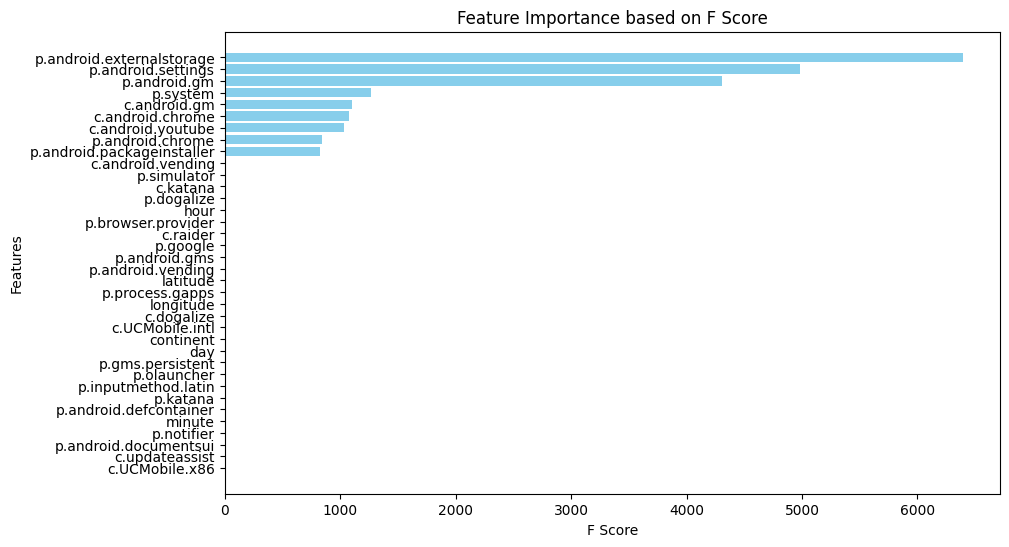

ANOVA F-Test Results:
                       Feature      F Score        P-Value
4    p.android.externalstorage  6393.184617   0.000000e+00
7           p.android.settings  4979.704667   0.000000e+00
6                 p.android.gm  4304.792152   0.000000e+00
3                     p.system  1262.313985  4.143448e-262
24                c.android.gm  1098.842905  5.796015e-230
25            c.android.chrome  1079.792836  3.445150e-226
26           c.android.youtube  1031.536994  1.329986e-216
8             p.android.chrome   839.547053  4.441665e-178
2   p.android.packageinstaller   822.449890  1.283244e-174
30           c.android.vending     6.855920   8.846675e-03
15                 p.simulator     2.997236   8.343416e-02
22                    c.katana     2.573877   1.086693e-01
14                  p.dogalize     2.312818   1.283395e-01
34                        hour     2.136001   1.439045e-01
21          p.browser.provider     2.034332   1.538096e-01
31                    c.raider    

In [163]:
f_scores, p_values = f_classif(features, target)

f_scores = pd.DataFrame({
    "Feature": features.columns,
    "F Score": f_scores,
    "P-Value": p_values

})

f_scores = f_scores.sort_values(by="F Score", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(f_scores["Feature"], f_scores["F Score"], color='skyblue')
plt.xlabel("F Score")
plt.ylabel("Features")
plt.title("Feature Importance based on F Score")
plt.gca().invert_yaxis()
plt.show()

print("ANOVA F-Test Results:")
print(f_scores)

- F-Score: A higher F-Score suggests a feature is more likely to be informative for distinguishing categories in the target.
- P-Value: Lower p-values indicate stronger evidence against the null hypothesis (that the feature means are the same across categories), suggesting that the feature is relevant.

As we can see from the results above, the most important features based on ANOVA F-Test are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- c.android.youtube
- c.android.chrome
- c.android.gm
- p.android.packageinstaller
- p.android.chrome

Also based on the p value:
- p.android.externalstorage
- p.android.settings
- p.android.gm

had p value 0, which means that they are the most important features, and they are statistically significant. Other features listed above also had really low p values, which means that they are also statistically significant.

The first 4 features are the same as in the Mutual Information test, which means that they are the most important features for the prediction.

### Correlation

In [164]:
corr = abs(train_data.corr()["mwra"])
corr.sort_values(ascending=False).head(15)

,mwra
mwra,1.000000
p.android.externalstorage,0.602459
p.android.settings,0.554415
p.android.gm,0.526562
p.system,0.317994
c.android.gm,0.298652
c.android.chrome,0.296281
c.android.youtube,0.290155
p.android.chrome,0.263839
p.android.packageinstaller,0.261324


Based on the correlation table, we can see that the most important features are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- c.android.youtube
- c.android.chrome
- c.android.gm
- p.android.packageinstaller
- p.android.chrome

All other features have a correlation coefficient close to 0, which means that they are not important for the prediction.

### Select from Model (Random Forest)

                       Feature  Importance
7           p.android.settings    0.172394
4    p.android.externalstorage    0.168902
6                 p.android.gm    0.105019
3                     p.system    0.058341
25            c.android.chrome    0.047679
8             p.android.chrome    0.045371
26           c.android.youtube    0.042465
24                c.android.gm    0.041664
2   p.android.packageinstaller    0.035171
23                  c.dogalize    0.031204


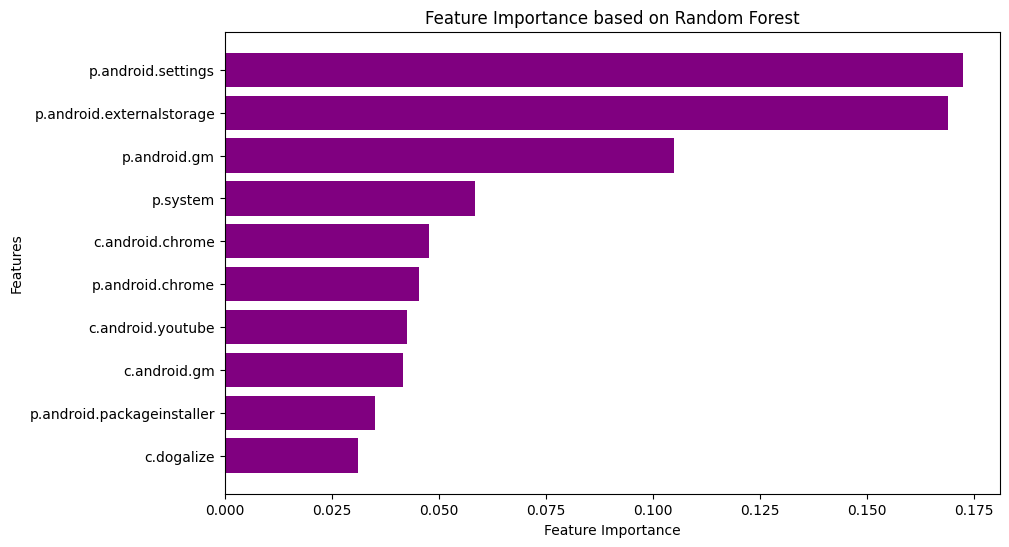

In [165]:
model = RandomForestClassifier(random_state=42)
model.fit(features, target)

selector = SelectFromModel(estimator=model, threshold="mean", prefit=True)
selector.fit(features, target)

feature_importances = model.feature_importances_
selected_features = features.columns[selector.get_support()]

importance_df = pd.DataFrame({
    "Feature": features.columns,
    "Importance": feature_importances
})
importance_df = importance_df[importance_df["Feature"].isin(selected_features)]
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print(importance_df)
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance based on Random Forest")
plt.gca().invert_yaxis()
plt.show()

In the plot above we can see that the most important features are:
- p.android.settings
- p.android.externalstorage
- p.android.gm
- p.system
- c.android.youtube
- p.android.chrome
- p.adnroid.packageinstaller
- c.android.chrome
- c.android.gm
- c.dogalize


### Results
After following 4 tests, let's write down the most important features for the prediction in descending order:
1. p.android.externalstorage
2. p.android.settings
3. p.android.gm
4. p.system
5. c.android.youtube
6. c.android.chrome
7. c.android.gm
8. c.android.packageinstaller
9. p.android.chrome

## Replication of preprocessing

In [166]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

### Data encoding

In [167]:
class ContinentEncoder(TransformerMixin):
    def __init__(self):
        self.continent_mapping = {
            'Asia': 1,
            'America': 2,
            'Europe': 3,
            'Africa': 4,
            'Australia': 5,
            'Indian': 6,
            'Pacific': 7
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['continent'] = X['continent'].map(self.continent_mapping)
        return X

In [168]:
class TsEncoder(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['ts'] = pd.to_datetime(X['ts'], format='%Y-%m-%d %H:%M:%S')
        X['day'] = X['ts'].dt.day
        X['hour'] = X['ts'].dt.hour
        X['minute'] = X['ts'].dt.minute
        X = X.drop(['ts'], axis=1)
        return X

### Data cleaning

In [169]:
class FeatureDropper(TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_drop, axis=1)

In [170]:
class OutlierRemover(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.transform_outliers)

    def transform_outliers(self, column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

      return cleaned_column

### Data transforming

In [171]:
class PowerTransformerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        self.power_transformer.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.power_transformer.transform(X[self.columns_to_transform])
        return X

In [172]:
class QuantileTransformerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.quantile_transformet = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)

    def fit(self, X, y=None):
        self.quantile_transformet.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.quantile_transformet.transform(X[self.columns_to_transform])
        return X

### Data scaling

In [173]:
class StandardScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.standard_scaler = StandardScaler()

    def fit(self, X, y=None):
        self.standard_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.standard_scaler.transform(X[self.columns_to_transform])
        return X

In [174]:
class MinMaxScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.min_max_scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.min_max_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.min_max_scaler.transform(X[self.columns_to_transform])
        return X

In [175]:
class RobustScalerGroup(TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
        self.robust_scaler = RobustScaler()

    def fit(self, X, y=None):
        self.robust_scaler.fit(X[self.columns_to_transform])
        return self

    def transform(self, X):
        X[self.columns_to_transform] = self.robust_scaler.transform(X[self.columns_to_transform])
        return X

### Pipeline

In [176]:
columns_to_drop = ['store_name', 'code', 'city', 'imei']

first_group = ['p.android.packageinstaller', 'p.system', 'p.android.externalstorage',
               'p.android.documentsui', 'p.android.gm', 'p.android.settings',
               'p.android.chrome', 'p.inputmethod.latin', 'p.android.gms',
               'c.katana', 'c.dogalize', 'c.android.gm','c.android.chrome',
               'c.android.youtube', 'c.UCMobile.intl', 'c.updateassist',
               'c.UCMobile.x86']

second_group = ['p.android.defcontainer', 'p.android.vending', 'p.dogalize',
                'p.simulator', 'p.google', 'p.process.gapps', 'p.katana',
                'p.gms.persistent', 'p.notifier', 'p.browser.provider',
                'c.android.vending', 'c.raider', 'minute']

third_group = ['latitude', 'longitude', 'p.olauncher', 'continent', 'day', 'hour']

In [179]:
pipeline = Pipeline([
    ('continent_encoder', ContinentEncoder()),
    ('ts_encoder', TsEncoder()),
    ('feature_dropper', FeatureDropper(columns_to_drop)),
    ('outlier_remover', OutlierRemover()),
    ('power_transformer_group1', PowerTransformerGroup(first_group)),
    ('quantile_transformer_group_2', QuantileTransformerGroup(second_group)),
    ('quantile_transformer_group_3', QuantileTransformerGroup(third_group)),
    ('standard_scaler_group_1', StandardScalerGroup(first_group)),
    ('min_max_scaler_group_2', MinMaxScalerGroup(second_group)),
    ('robust_scaler_group_3', RobustScalerGroup(third_group)),
])

In [180]:
test_data_tr = pipeline.fit_transform(test_data)

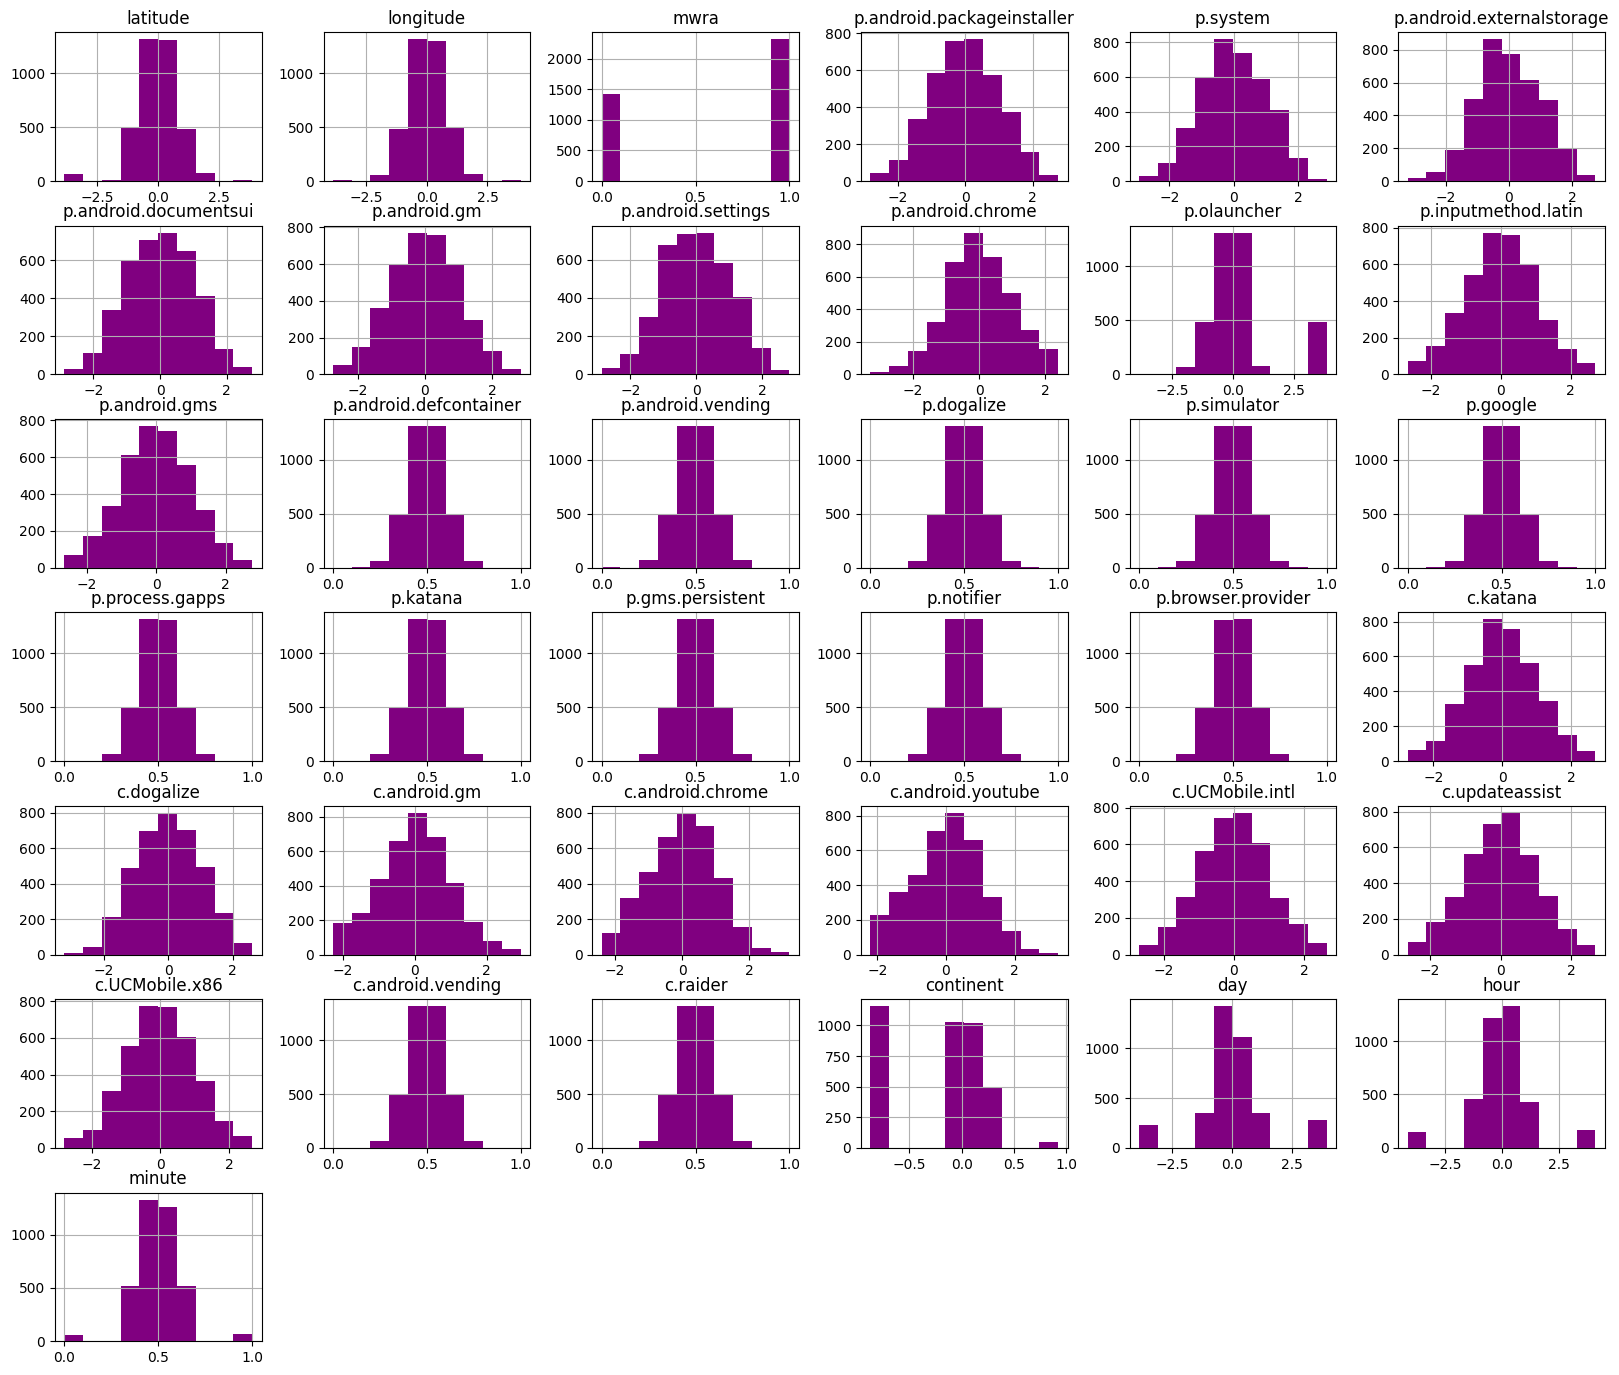

In [183]:
test_data_tr.hist(figsize=(20, 17), color='purple')
plt.show()